In [216]:
#import plotting dependencies
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates


#import data analysis dependencies
import pandas as pd
import numpy as np

#import SQL Alchemy dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

# Reflect Tables into SQLAlchemy ORM

In [217]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [218]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [219]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [220]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [221]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

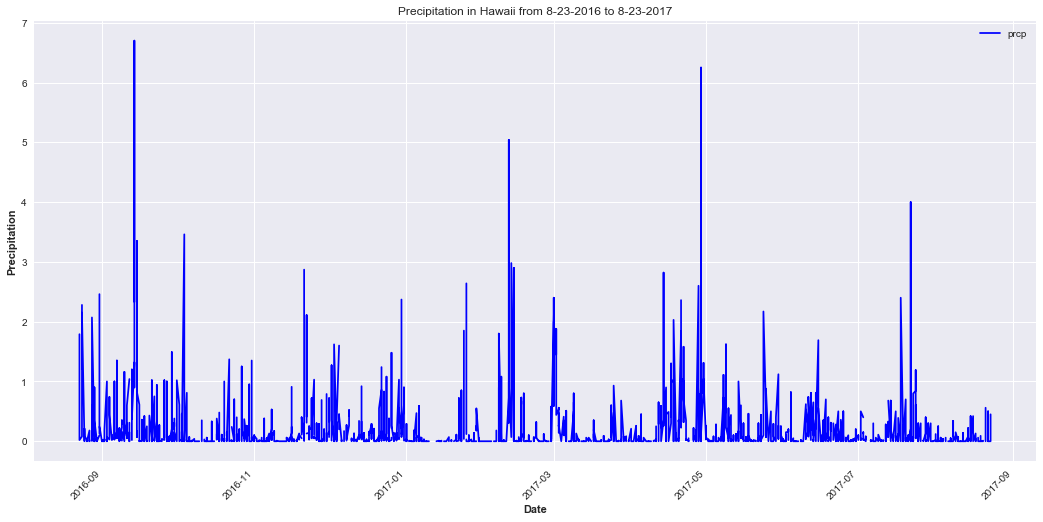

In [222]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation_analysis_1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()
# Calculate the date 1 year ago from the last data point in the database
pre_df = pd.DataFrame(precipitation_analysis_1)


# Perform a query to retrieve the data and precipitation scores

pre_df['date'] = pd.to_datetime(pre_df['date'])

# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df = pre_df.set_index('date')
prec_df.head()


# Use Pandas Plotting with Matplotlib to plot the data
prec_plot = prec_df.plot(figsize = (16, 9), sort_columns=True, rot=45, use_index=True, legend=True, grid=True, color='b')
plt.ylabel('Precipitation', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title("Precipitation in Hawaii from 8-23-2016 to 8-23-2017")
plt.show()

![precipitation](Images/precipitation.png)

In [223]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prec_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [224]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Station.id).count()
station_num

9

In [225]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_station = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
# List the stations and the counts in descending order.
most_active_station

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [226]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
waihee_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281", Measurement.station == Station.station, Measurement.date >="2016-08-23", Measurement.date <="2017-08-23").\
all()

# highest temperature recorded, and average temperature most active station?
len(waihee_tobs)


352

In [227]:
print(waihee_tobs[0][0])


77.0


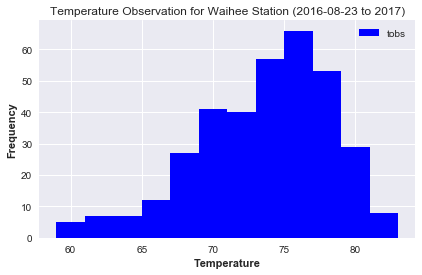

In [228]:
# Choose the station with the highest number of temperature observations.

temperatures = [temp[0] for temp in waihee_tobs]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temperatures, bins=12, color='b')
plt.title("Temperature Observation for Waihee Station (2016-08-23 to 2017)")
plt.ylabel('Frequency', weight='bold')
plt.xlabel('Temperature', weight='bold')
labels = ['tobs']
plt.legend(labels)

![precipitation](Images/station-histogram.png)

In [229]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [235]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
def calc_temps(start, end):
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    avg_temp = np.mean(temperatures)
    lowest_temp = min(temperatures)
    highest_temp = max(temperatures)
    
plt.figure(figsize=(3,5))
plt.bar(1, avg_temp, yerr=(highest_temp - lowest_temp), tick_label='', color='salmon')
plt.ylabel("Temperature", weight="bold")
plt.title("Average Trip Temperature", weight="bold")
plt.show()


NameError: name 'avg_temp' is not defined

<Figure size 216x360 with 0 Axes>

In [236]:
# Plot the results from your previous query as a bar chart. 

columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'])
    
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


NameError: name 'inspector' is not defined

In [234]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
